In [1]:
import msprime as msp
import random
import numpy as np
import scipy
from scipy import stats
import math
import pandas
import itertools
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import allel; print('scikit-allel', allel.__version__)
from allel.stats.misc import jackknife

scikit-allel 1.2.1


## MSPRIME SIMULATIONS

This run, recombination = 1.25 e-8 (equal to mu)
This run has 1 run with no replicate simulations, L=250M (large chr 2 sized sample).
10 samples per population. The full haplotype matrix is returned.
Simulates the coalescent with recombination under the specified model parameters and returns the resulting :class:`tskit.TreeSequence`. Note that Ne is the effective diploid population size (so the effective number of genomes in the population is 2*Ne), but ``sample_size`` is the number of (monoploid) genomes sampled.

Source pops related by ...
nS vector of sample sizes (monoploid genomes) in each S, i.e. (nS1, nS2, nS3)
tS vector ages of samples in each S, i.e. (tS1, tS2, tS3)
t12 time of S1,S2 split (first split)
t123 time of ((S1, S2), S3) split
ta vector of admixture times from S2 and S3 to S1
f vector of admixture fractions from from S2 and S3 to S1
N vector of effective sizes in order of population numbers
L is length of simulated region in bases (set to 250MB here)

Here we are looking at the % shared archaic SNP blocks between Ayta and Papuan for Neanderthal and Denisovan.
The model we are testing is the Null, with a single admixture event from Neanderthal into the shared ancestor of all Non-Africans, and a single Denisovan admixture event into the ancestor of Papuans and Ayta.
Basically we are looking to see if the observed pattern of reduced overlap in putative tracts for Denisovans in Ayta & Papuan could feasibly be due to ILS alone.

In [2]:
# enter functions

DEN0, DEN1, DEN2, DEN3, AFR, CEU, PAP, AYT, NEA, CHM = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9


def set_up_pops(nS, tS):
    #historical series within pop S1
    samples = [msp.Sample(population=DEN0, time=tS[0])]*(1*nS[0]) # Denisovan 0
    samples.extend([msp.Sample(population=DEN1, time=tS[0])]*(1*nS[1])) # Denisovan 1
    samples.extend([msp.Sample(population=DEN2, time=tS[0])]*(1*nS[2])) # Denisovan 2
    samples.extend([msp.Sample(population=DEN3, time=tS[1])]*(1*nS[3])) # Denisovan 3 (Altai)
    samples.extend([msp.Sample(population=AFR, time=tS[0])]*(1*nS[4])) # Africa
    samples.extend([msp.Sample(population=CEU, time=tS[0])]*(1*nS[5])) # European
    samples.extend([msp.Sample(population=PAP, time=tS[0])]*(1*nS[6])) # Papuan
    samples.extend([msp.Sample(population=AYT, time=tS[0])]*(1*nS[7])) # Negrito (Ayta)
    samples.extend([msp.Sample(population=NEA, time=tS[2])]*(1*nS[8])) # Neanderthal
    samples.extend([msp.Sample(population=CHM, time=tS[0])]*(1*nS[9])) # Chimp
    return samples


def set_up_demography(t67, t75, t54, t10, t20, t03, t83, t34, t49, ta1, ta2, ta3, f):
    #divergence of source populations (topology of tree)
    source_divergence = [msp.MassMigration(time=t67, source=PAP, destination=AYT, proportion=1),  
                        msp.MassMigration(time=t75, source=AYT, destination=CEU, proportion=1), 
                        msp.MassMigration(time=t54, source=CEU, destination=AFR, proportion=1), 
                        msp.MassMigration(time=t10, source=DEN1, destination=DEN0, proportion=1), 
                        msp.MassMigration(time=t20, source=DEN2, destination=DEN0, proportion=1),
                        msp.MassMigration(time=t03, source=DEN0, destination=DEN3, proportion=1),
                        msp.MassMigration(time=t83, source=NEA, destination=DEN3, proportion=1),
                        msp.MassMigration(time=t34, source=DEN3, destination=AFR, proportion=1),
                        msp.MassMigration(time=t49, source=AFR, destination=CHM, proportion=1)] 
    #admixture times and proportions
    admix = [msp.MassMigration(time=ta1, source=AYT, destination=DEN2, proportion=f[0]), #fraction from Denisovan 2 to Ayta
            msp.MassMigration(time=ta2, source=PAP, destination=DEN1, proportion=f[1]), #fraction from Denisovan 1 to Papuan
            msp.MassMigration(time=ta3, source=CEU, destination=NEA, proportion=f[2])] #fraction from Neanderthal to OoA pops
    #population parameter changes
    N_change = [msp.PopulationParametersChange(time=2400, initial_size=2000, growth_rate=0, population_id=CEU),
               msp.PopulationParametersChange(time=2800, initial_size=5000, growth_rate=0, population_id=CEU)]
    #combine and sort the demography
    demography = source_divergence + admix + N_change
    return sorted(demography, key = lambda x: x.time)


# Enter data
L=100000000
mu=1.25e-8
r=1.25e-8

generation_time=25
T67=46000/generation_time  # PAP joins AYT  
T75=55000/generation_time  # AYT joins CEU 
T54=70000/generation_time  # CEU joins AFR
T10=200000/generation_time # Denisovan 1 joins Denisovan 0
T20=200000/generation_time # Denisovan 2 joins Denisovan 0 
T03=300000/generation_time # Denisovan 0 joins Denisovan 3 (Altai) 
T83=400000/generation_time # Neanderthal joins Denisovan 3 (Altai) 
T34=600000/generation_time # Denisovan 3 (Altai) joins AFR
T49=4000000/generation_time # AFR joins Chimp
 
TA1=35000/generation_time   
TA2=45000/generation_time   
TA3=68000/generation_time   

TS_NEA=60000/generation_time
TS_DEN3=40000/generation_time

NumSamples=100
nS=[10]*10
tS=[0,TS_DEN3,TS_NEA]
f=[0.06, 0.04, 0.02]
N=[1500,1500,1500,1500,15000,5000,3500,3500,2000,30000]
seed=None

samples = set_up_pops(nS,tS)
demography = set_up_demography(T67, T75, T54, T10, T20, T03, T83, T34, T49, TA1, TA2, TA3, f)
pops = [msp.PopulationConfiguration(initial_size = n) for n in N]

# Use demography debugger for sanity check that you are simulating correct demography
dd = msp.DemographyDebugger(
    population_configurations=pops,
    demographic_events=demography)
dd.print_history()

Epoch: 0 -- 1400.0 generations
     start     end      growth_rate |     0        1        2        3        4        5        6        7        8        9    
   -------- --------       -------- | -------- -------- -------- -------- -------- -------- -------- -------- -------- -------- 
0 | 1.5e+03  1.5e+03              0 |     0        0        0        0        0        0        0        0        0        0    
1 | 1.5e+03  1.5e+03              0 |     0        0        0        0        0        0        0        0        0        0    
2 | 1.5e+03  1.5e+03              0 |     0        0        0        0        0        0        0        0        0        0    
3 | 1.5e+03  1.5e+03              0 |     0        0        0        0        0        0        0        0        0        0    
4 | 1.5e+04  1.5e+04              0 |     0        0        0        0        0        0        0        0        0        0    
5 |  5e+03    5e+03               0 |     0        0        0     

## run simulations

In [3]:
sims = msp.simulate(samples=samples, Ne=N[0], population_configurations=pops, demographic_events=demography, mutation_rate=mu, length=L, recombination_rate=r, record_migrations=True, random_seed=seed)

# Comparing genuine segments from admixture events
## function to get set of tracts that migrated during admixture events 
## DEN1 = tracts migrating from shared Papuan into Denisovan 1
## DEN2 = tracts migrating from Ayta into Denisovan 2
## NEA = tracts migrating from shared ancestor of Ayta / Papuan into Neanderthal

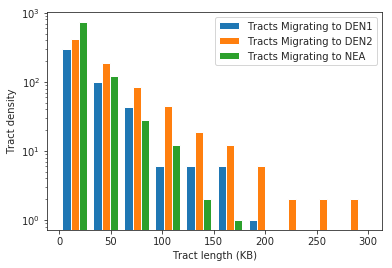

In [35]:
def get_migrating_tracts(ts):
    migrating_tracts_DEN1, migrating_tracts_DEN2, migrating_tracts_NEA = [], [], []
    # Get all tracts that migrated into the Denisovan populations
    for migration in ts.migrations():
        if migration.dest == DEN1:
            migrating_tracts_DEN1.append((migration.left, migration.right))
        elif migration.dest == DEN2:
            migrating_tracts_DEN2.append((migration.left, migration.right))
        elif migration.dest == NEA:
            migrating_tracts_NEA.append((migration.left, migration.right))
    return np.array(migrating_tracts_DEN1), np.array(migrating_tracts_DEN2), np.array(migrating_tracts_NEA) 

migrating_DEN1, migrating_DEN2, migrating_NEA = get_migrating_tracts(sims)
#np.savetxt('ALT2_MigTracts_DEN1.txt', migrating_DEN1)
#np.savetxt('ALT2_MigTracts_DEN2.txt', migrating_DEN2)
#np.savetxt('ALT2_MigTracts_NEA.txt', migrating_NEA)

# Compare length distributions of admixing segments

# plot length distribitions of migrating tracts

kb = 1 / 1000
plt.hist([
    (migrating_DEN1[:,1] - migrating_DEN1[:,0]) * kb,
    (migrating_DEN2[:,1] - migrating_DEN2[:,0]) * kb,
    (migrating_NEA[:,1] - migrating_NEA[:,0]) * kb],    
    label=["Tracts Migrating to DEN1", "Tracts Migrating to DEN2", "Tracts Migrating to NEA"]
)
plt.yscale('log')
plt.legend()
plt.xlabel("Tract length (KB)")
plt.ylabel("Tract density")
#plt.savefig('plot_ALT2_tract_distribution.pdf', dpi=600, bbox_inches='tight')

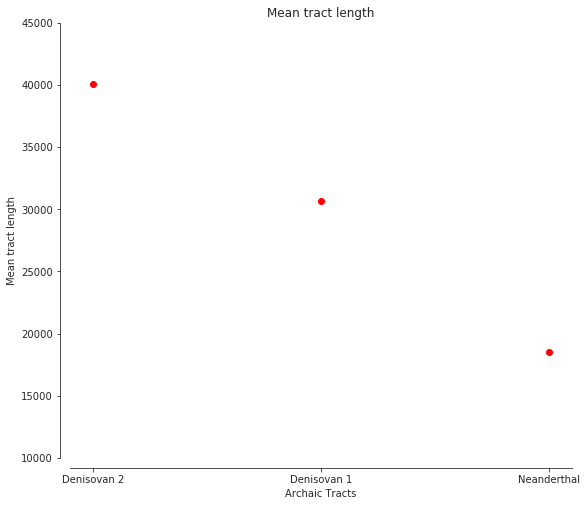

In [5]:
## want to look at average length of DEN tract lengths unique to Ayta, unique to Papuan, and shared between each
## plot mean number and tract lengths from each (means and SE across 10 runs)

def plot_mean_tract_lengths(den1, den2, nea, title=None):
    mean_tract_den1 = np.mean(den1[:,1] - den1[:,0], axis=0).astype(int)
    mean_tract_den2 = np.mean(den2[:,1] - den2[:,0], axis=0).astype(int)
    mean_tract_nea = np.mean(nea[:,1] - nea[:,0], axis=0).astype(int)
    x = ['Denisovan 2','Denisovan 1','Neanderthal']
    y = [mean_tract_den2, mean_tract_den1, mean_tract_nea]
    fig, ax = plt.subplots(figsize=(9, 8))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y, 'ro')
#    ax.set(ylim=(0, 25))
    ax.set_xlabel('Archaic Tracts')
    ax.set_ylabel('Mean tract length')
    ax.set_ylim(10000,45000)
    if title:
        ax.set_title(title)     
    
plot_mean_tract_lengths(migrating_DEN1, migrating_DEN2, migrating_NEA, title='Mean tract length')

In [6]:
# these are the unique tracts found in each population. By definition there are no shared tracts under this model

# Comparing putatively assigned "SNP tracts"

## Get dataset
## get whole haplotype array for 90 samples (10 per pop), add columns for variant ID and pos 

In [7]:
# function to get copy of dataset
def get_dataset(sim_mat):
    mat_full = np.zeros((sim_mat.shape[0],sim_mat.shape[1]+2))
    mat_full[:, 2:] = sim_mat
    return mat_full

geno_mat_info = get_dataset(sims.genotype_matrix())

for variant in sims.variants():
        geno_mat_info[variant.site.id,0]=variant.site.id+1
        geno_mat_info[variant.site.id,1]=variant.site.position

In [8]:
# function to downsample full haplotype array to ordered and sorted panel of 0.5M SNPs (will lead to 500 blocks)
# addition of chimp lineage means many SNPs now completely derived or ancestral in all modern samples. Remove these.

def downsample_sort(big_arr, size):
    all_anc_index = big_arr[:,42:82].sum(axis=1)!=0     # index SNPs ancestral in all modern pop samples
    sub_arr1 = big_arr[all_anc_index,:]
    all_der_index = sub_arr1[:,42:82].sum(axis=1)!=40    # index SNPs derived in all modern pop samples
    sub_arr2 = sub_arr1[all_der_index,:]

    sub_arr3 = sub_arr2[np.random.choice(sub_arr2.shape[0], size, replace=False)]    # Downsample to panel of given SNPs
    sort_arr = sub_arr3[sub_arr3[:,0].argsort()] # sort based on first column (SNP index)
    return sort_arr

geno_mat_sub_ord = downsample_sort(geno_mat_info.astype(int), 250000)
geno_mat_sub_ord[:,0] = np.arange(1,250001)

In [9]:
# Function uses all 10 samples per pop to get allele counts for estimating D stats
# input data need to be of scikit.allel form 'AlleleCountsArray' for each population, with each SNP represented by number of anc & der alleles
# function to take haplotype array and count alleles in each population sample of 5 diploids: 

def pop_sample_ac(geno_mat):
    haplo_arr = allel.HaplotypeArray(geno_mat)
    ac_one = haplo_arr[:,0:10].count_alleles()
    ac_two = haplo_arr[:,10:20].count_alleles()
    ac_three = haplo_arr[:,20:30].count_alleles()
    ac_four = haplo_arr[:,30:40].count_alleles()
    ac_five = haplo_arr[:,40:50].count_alleles()
    ac_six = haplo_arr[:,50:60].count_alleles()
    ac_seven = haplo_arr[:,60:70].count_alleles()
    ac_eight = haplo_arr[:,70:80].count_alleles()
    ac_nine = haplo_arr[:,80:90].count_alleles()
    ac_ten = haplo_arr[:,90:100].count_alleles()
    # stack arrays with frames = population allele counts for all SNPs
    arrays = [ac_one,ac_two,ac_three,ac_four,ac_five,ac_six,ac_seven,ac_eight,ac_nine,ac_ten]
    ac_All = np.stack(arrays, axis=0)
    return ac_All

ac_AllSamples = pop_sample_ac(geno_mat_sub_ord[:, 2:].astype(int))

# make index array of relevant populations for different D test comparisons (D{AFR,DEN3;AYT/PAP,CEU})
D_test_index = np.array([[4,3,5,7],[4,3,5,6]])   # may need to turn order of Ayta/Papua (7/6) and CEU (5)

# array to take D test results output for all above comparisons, returns d,se,z
D_mean_arr = np.array([(allel.average_patterson_d(ac_AllSamples[x[0]], ac_AllSamples[x[1]], ac_AllSamples[x[2]], ac_AllSamples[x[3]], 1000)[0:3]) for x in D_test_index])

# Perform overall D test 

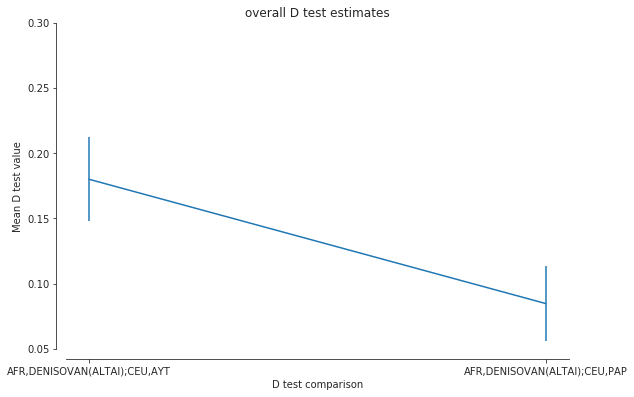

In [10]:
# Define function to plot mean D results across 10 runs 
def plot_D_average(res_array, title=None):
    x = ['AFR,DENISOVAN(ALTAI);CEU,AYT','AFR,DENISOVAN(ALTAI);CEU,PAP']
    y = res_array[0:2,0]
    sterr = res_array[0:2,1]*1.96
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.despine(ax=ax, offset=10)
    ax.errorbar(x, y, yerr=sterr)
    ax.set(ylim=(0.05, 0.30))
    ax.set_xlabel('D test comparison')
    ax.set_ylabel('Mean D test value')
    if title:
        ax.set_title(title)

# overall D test comparison
plot_D_average(D_mean_arr, title='overall D test estimates')

In [11]:
# Divide the allele count array up into 250 blocks of 1000 SNPs for each of the 10 pop samples.
# perform mean patterson D test (jackknife=100) on given populations for each block

def get_D_test_blocks(ac_arr,pop1,pop2,pop3,pop4):
    arr_tp1 = np.transpose(ac_arr, (1,0,2))    # order SNPS,INDS,AC
    arr_rshp = arr_tp1.reshape(250,1000,10,2)    # reshape with 500 blocks
    arr_tp2 = np.transpose(arr_rshp, (0,2,1,3))    # transpose again in preparation for D tests
    mean_D_blocks = np.array([(allel.average_patterson_d(block[pop1], block[pop2], block[pop3], block[pop4], 100)[0:3]) for block in arr_tp2])
    return mean_D_blocks

# For each block returns: meanD, se, z

## ASSIGNING PUTATIVE DENISOVAN BLOCKS

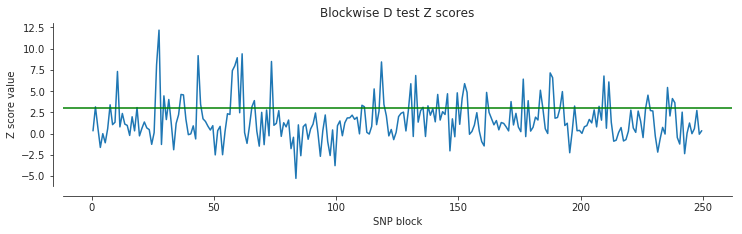

In [12]:
# First test for Denisovan ancestry in each block for Ayta
D1_res_AYT = get_D_test_blocks(ac_AllSamples,AFR,DEN3,CEU,AYT)

# Define function to quickly plot Z score results and check sufficient are > 3
def plot_Z_scores(D_array, title=None):
    bins =  np.arange(0, 251)
    x = (bins[1:] + bins[:-1])/2    # use block midpoints as x-coordinates
    y = D_array[:,2]
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.axhline(3, color='green')
    ax.set_xlabel('SNP block')
    ax.set_ylabel('Z score value')
    if title:
        ax.set_title(title)

# Plot blockwise z scores for AYT
plot_Z_scores(D1_res_AYT, title='Blockwise D test Z scores')

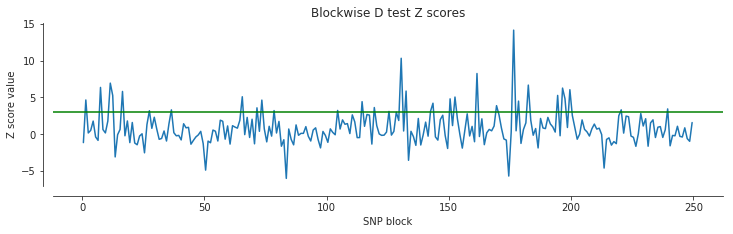

In [13]:
# Now test for Denisovan ancestry in each block for Papuan
D1_res_PAP = get_D_test_blocks(ac_AllSamples,AFR,DEN3,CEU,PAP)

# Plotted blockwise Z score results should have less than AYT > 3
plot_Z_scores(D1_res_PAP, title='Blockwise D test Z scores')

/home/jamesmckenna/miniconda3/lib/python3.6/site-packages/allel/stats/admixture.py:430: RuntimeWarning: invalid value encountered in true_divide
  vb = num_bsum / den_bsum
/home/jamesmckenna/miniconda3/lib/python3.6/site-packages/allel/stats/admixture.py:437: RuntimeWarning: divide by zero encountered in double_scalars
  z = d_avg / se
/home/jamesmckenna/miniconda3/lib/python3.6/site-packages/allel/stats/admixture.py:423: RuntimeWarning: invalid value encountered in double_scalars
  d_avg = np.nansum(num) / np.nansum(den)
/home/jamesmckenna/miniconda3/lib/python3.6/site-packages/allel/stats/admixture.py:434: RuntimeWarning: invalid value encountered in double_scalars
  statistic=lambda n, d: np.sum(n) / np.sum(d))
/home/jamesmckenna/miniconda3/lib/python3.6/site-packages/allel/stats/admixture.py:437: RuntimeWarning: invalid value encountered in double_scalars
  z = d_avg / se


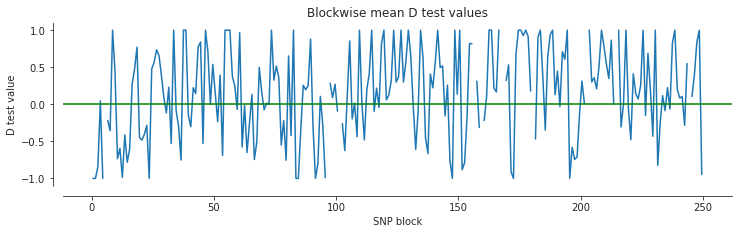

In [14]:
# Now the second D test. If a block is positive from this and overlaps with a > 3 z score in previous D test,
# we assign Denisovan ancestry
D2_res_AYT = get_D_test_blocks(ac_AllSamples,AFR,AYT,NEA,DEN3)

# Define function to quickly plot mean D results 
def plot_meanD(D_array, title=None):
    bins =  np.arange(0, 251)
    x = (bins[1:] + bins[:-1])/2    # use block midpoints as x-coordinates
    y = D_array[:,0]
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.axhline(0, color='green')
    ax.set_xlabel('SNP block')
    ax.set_ylabel('D test value')
    if title:
        ax.set_title(title)

# Plot blockwise z scores for given D test

plot_meanD(D2_res_AYT, title='Blockwise mean D test values')

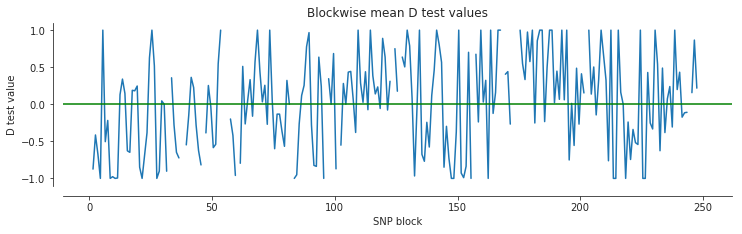

In [15]:
# Do the same for Papuan
D2_res_PAP = get_D_test_blocks(ac_AllSamples,AFR,PAP,NEA,DEN3)

plot_meanD(D2_res_PAP, title='Blockwise mean D test values')

In [16]:
# If a block has a z-score > +3 in D1, and a positive D value in D2. Assign Denisovan ancestry to it.

def get_DEN_blocks(d1_PAP, d1_AYT, d2_PAP, d2_AYT):
    put_DEN_PAP = (d1_PAP[:,2] >= 3) & (d2_PAP[:,0] > 0)
    put_DEN_AYT = (d1_AYT[:,2] >= 3) & (d2_AYT[:,0] > 0)
    DEN_blocks_PAP = np.sum(put_DEN_PAP)
    DEN_blocks_AYT = np.sum(put_DEN_AYT)
    total_DEN_blocks = DEN_blocks_PAP + DEN_blocks_AYT
    shared_DEN_blocks = np.sum((put_DEN_PAP == True) & (put_DEN_AYT == True)) / total_DEN_blocks * 100

    return shared_DEN_blocks, DEN_blocks_PAP, DEN_blocks_AYT

shared_DEN_PAPvsAYT, putative_DEN_PAP, putative_DEN_AYT = get_DEN_blocks(D1_res_PAP, D1_res_AYT, D2_res_PAP, D2_res_AYT)

In [17]:
# Percentage shared putative Denisovan blocks between Papuan & Ayta
shared_DEN_PAPvsAYT

13.20754716981132

In [18]:
# Number putative Denisovan blocks in Papuan
putative_DEN_PAP

19

In [19]:
# Number putative Denisovan blocks in Ayta
putative_DEN_AYT

34

## ASSIGNING PUTATIVE NEANDERTHAL BLOCKS

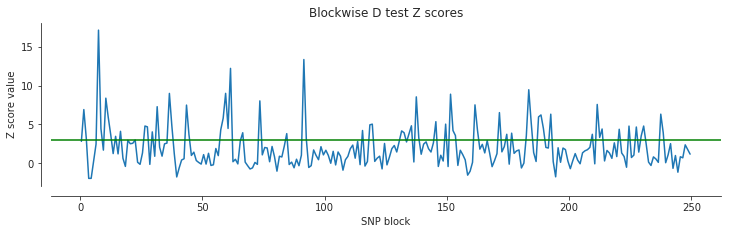

In [20]:
# First test for Neanderthal ancestry in each block in Ayta
D3_res_AYT = get_D_test_blocks(ac_AllSamples,CHM,NEA,AFR,AYT)

# as a quick check, plot Z scores to make sure a decent number are > 3
# Plot blockwise z scores for given D test

plot_Z_scores(D3_res_AYT, title='Blockwise D test Z scores')

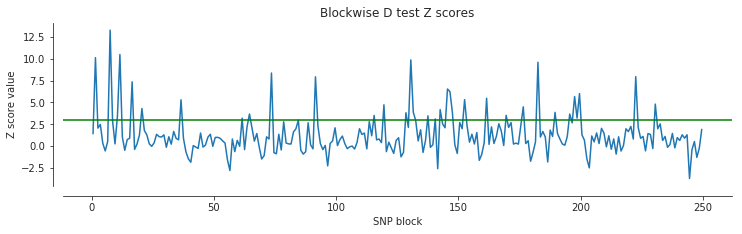

In [21]:
# First test for Neanderthal ancestry in each block in Papuan
D3_res_PAP = get_D_test_blocks(ac_AllSamples,CHM,NEA,AFR,PAP)

# as a quick check, plot Z scores to make sure similar Neanderthal ancestry as AYT (probably lower)
plot_Z_scores(D3_res_PAP, title='Blockwise D test Z scores')

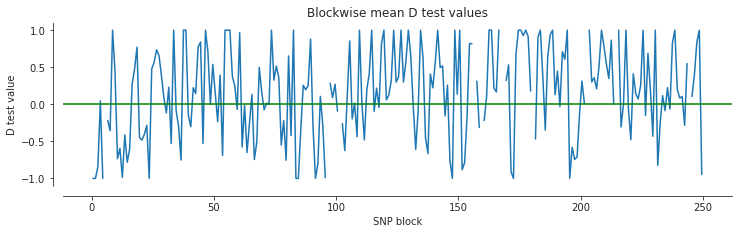

In [22]:
# Do the 2nd D test. If a block is negative from this & overlaps with a > 3 z score in last test, assign Neanderthal
D4_res_AYT = get_D_test_blocks(ac_AllSamples,AFR,AYT,NEA,DEN3)

# Plot blockwise z scores for given D test
plot_meanD(D4_res_AYT, title='Blockwise mean D test values')

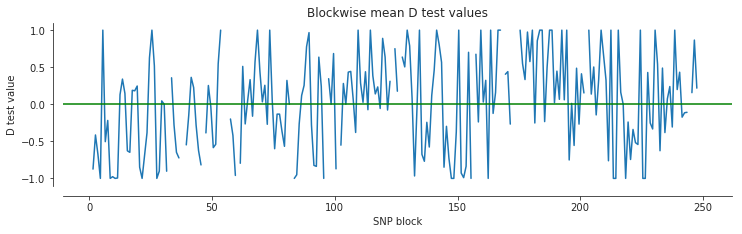

In [23]:
# The same for Papuan. 
D4_res_PAP = get_D_test_blocks(ac_AllSamples,AFR,PAP,NEA,DEN3)
plot_meanD(D4_res_PAP, title='Blockwise mean D test values')

In [24]:
# Function to assign putative Neanderthal blocks per population.

def get_NEA_blocks(d3_PAP, d3_AYT, d4_PAP, d4_AYT):
    put_NEA_PAP = (d3_PAP[:,2] >= 3) & (d4_PAP[:,0] < 0)   # assign NEA if first D test has z-score >3 and 2nd D test has negative D value
    put_NEA_AYT = (d3_AYT[:,2] >= 3) & (d4_AYT[:,0] < 0)
    NEA_blocks_PAP = np.sum(put_NEA_PAP)
    NEA_blocks_AYT = np.sum(put_NEA_AYT)
    total_NEA_blocks = NEA_blocks_PAP + NEA_blocks_AYT
    shared_NEA_blocks = np.sum((put_NEA_PAP == True) & (put_NEA_AYT == True)) / total_NEA_blocks * 100   # get % of blocks that are True in both
    return shared_NEA_blocks, NEA_blocks_PAP, NEA_blocks_AYT

shared_NEA_PAPvsAYT, putative_NEA_PAP, putative_NEA_AYT = get_NEA_blocks(D3_res_PAP, D3_res_AYT, D4_res_PAP, D4_res_AYT)

# Percentage shared putative Neanderthal blocks between Papuan & Ayta
shared_NEA_PAPvsAYT

20.930232558139537

In [25]:
# Number shared putative Neanderthal blocks
np.sum(((D3_res_PAP[:,2] >= 3) & (D4_res_PAP[:,0] < 0) == True) & ((D3_res_AYT[:,2] >= 3) & (D4_res_AYT[:,0] < 0) == True))

9

In [26]:
# Number shared putative Denisovan blocks
np.sum(((D1_res_PAP[:,2] >= 3) & (D2_res_PAP[:,0] > 0) == True) & ((D1_res_AYT[:,2] >= 3) & (D2_res_AYT[:,0] > 0) == True))

7

In [27]:
# Percentage shared putative Neanderthal blocks between Papuan & Ayta
shared_DEN_PAPvsAYT

13.20754716981132

In [28]:
# Number putative Neanderthal blocks in Ayta
putative_NEA_AYT

25

In [29]:
putative_NEA_PAP

18

In [30]:
putative_DEN_AYT

34

In [31]:
putative_DEN_PAP

19

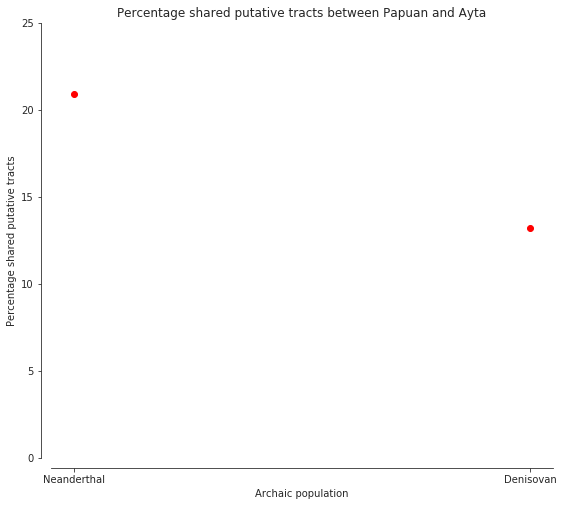

In [32]:
# plot percentage shared blocks in population comparison

def plot_shared_blocks(shared_NEA, shared_DEN, title=None):
    x = ['Neanderthal','Denisovan']
    y = [shared_NEA,shared_DEN]
    fig, ax = plt.subplots(figsize=(9, 8))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y, 'ro')
    ax.set(ylim=(0, 25))
    ax.set_xlabel('Archaic population')
    ax.set_ylabel('Percentage shared putative tracts')
    if title:
        ax.set_title(title)     

plot_shared_blocks(shared_NEA_PAPvsAYT, shared_DEN_PAPvsAYT, title='Percentage shared putative tracts between Papuan and Ayta')

In [33]:
# function to check how many blocks per population are being assigned both Neanderthal AND Denisovan in the two sets of tests
# Should be 0 for both populations!

def check_mis_ID(D1_res_PAP, D2_res_PAP, D3_res_PAP, D4_res_PAP, D1_res_AYT, D2_res_AYT, D3_res_AYT, D4_res_AYT):
    put_DEN_PAP = (D1_res_PAP[:,2] >= 3) & (D2_res_PAP[:,0] > 0)
    put_NEA_PAP = (D3_res_PAP[:,2] >= 3) & (D4_res_PAP[:,0] < 0)
    mis_ID_PAP = np.sum((put_NEA_PAP == True) & (put_DEN_PAP == True))
    put_DEN_AYT = (D1_res_AYT[:,2] >= 3) & (D2_res_AYT[:,0] > 0)
    put_NEA_AYT = (D3_res_AYT[:,2] >= 3) & (D4_res_AYT[:,0] < 0)
    mis_ID_AYT = np.sum((put_NEA_AYT == True) & (put_DEN_AYT == True))
    return mis_ID_PAP, mis_ID_AYT

Papuan_mis_ID, Ayta_mis_ID = check_mis_ID(D1_res_PAP, D2_res_PAP, D3_res_PAP, D4_res_PAP, D1_res_AYT, D2_res_AYT, D3_res_AYT, D4_res_AYT)

#Papuan_mis_ID
Papuan_mis_ID

0

In [34]:
#Papuan_mis_ID
Ayta_mis_ID

0

The expectation here is that Papuan & Ayta share more putative Neanderthal than putative Denisovan blocks.

Empirical data suggest this difference should be Denisovan ~7% & Neanderthal ~19 %. Simulated findings are pretty close: 10% and 18%

Things to ponder:
How do D values compare?

Your SNPs are more densely packed than the real SNP panel for chromosome 2. May act to increase power to detect continuous tracts of the genome. The less densely SNPs are packed, the less power the putative tract method is likely to be. For this reason, try the same but downsample to only 145 blocks, as suggested.
The way you are choosing polymorphisms may be unexpectedly affecting results. SNP ascertainment. You exclude all sites that are fixed derived or ancestral amongst all modern populations. 

Would also be nice to explore the overlap and sensitivity of the 'putative tract assignment' to the ACTUAL admixed segments!

The actual density of the SNP panel used by Max is 1.6M/3.5B*100 = 0.0457. And (100M/100)*0.0457=~100k.
So on this run I am downsampling to the mean SNP density used on the empirical data.

Why are we not doing the same D-test for Denisovan? D{Chimp,DEN3;AFR,X} followed by D{AFR,X;NEA,DEN}